<a href="https://colab.research.google.com/github/TemrinaDarya/turbines-2022/blob/hw2/TemrinaDarya_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install iapws

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 33.8 MB/s 
  Created wheel for iapws: filename=iapws-1.5.3-py3-none-any.whl size=114282 sha256=395cf0e7dc0bed44daf174efe1a0a0c2f15b3207b114d89a00cc7353d15b8896
  Stored in directory: /root/.cache/pip/wheels/31/41/85/a38aabccfd7dea1498653150e52ad2b2d7e3a8199263b8e09a
Successfully built iapws


Задача 1 Построить график зависимости термического КПД от давления промежуточного перегрева водяного пара для условий примера: Р0=13 МПа; t0=540 °С; Рк=5 кПа. Параметры промперегрева: Рпп=1, 2, 3, 4, 5, 6 МПа; tпп=540 °С.

In [ ]:
# Импорты
import iapws
from iapws import IAPWS97 as gas
from typing import Optional, Tuple, List, Union
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Константы
MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [ ]:
# Функции
def eff(p_0, t_0, p_k, p_middle, t_middle):
    point_0_start = gas(P=p_0 * unit, T=t_0)
    point_0_end = gas(P=p_middle * unit, s=point_0_start.s)
    point_1_start = gas(P=p_middle * unit, T=t_middle)
    point_condenser = gas(P=p_k * unit, s=point_1_start.s)
    point_pump = gas(P=p_k * unit, x=0)
    useful_energy = (point_0_start.h - point_0_end.h) + (point_1_start.h - point_condenser.h)
    full_energy = (point_0_start.h - point_pump.h) + (point_1_start.h - point_0_end.h)
    efficiency = round(useful_energy / full_energy * 100, 3)
    return efficiency


Ответ на задачу 2.1 = [44.786, 45.17, 45.222, 45.16, 45.043, 44.897]


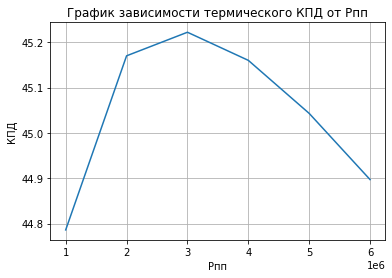

In [ ]:
#Начальные параметры 
p_0 = 13 * MPa
t_0 = to_kelvin(540)
p_k = 5 * kPa
p_middle = list(range(1, 7))
t_middle = to_kelvin(540)
p_middle = [x * 10**6 for x in p_middle]


effpp = [eff(p_0, t_0, p_k, pm_value, t_middle) for pm_value in p_middle]

print(f'Ответ на задачу 2.1 = {effpp}')

plt.plot(p_middle, effpp)
plt.grid(True)
plt.title('График зависимости термического КПД от Pпп')
plt.ylabel('КПД')
plt.xlabel('Pпп')
plt.show()


Задача 2 Написать код для решения задачи оптимизации параметров промежуточного перегрева Pпп и tпп для свободных начальных параметров Р0, t0, Рк. Сделаем допущение, что начальная точка процесса расширения всегда находится в зоне перегретого пара. Решение должно выдавать параметры промежуточного перегрева и термический КПД при них.

In [ ]:
def construct_cycle_points(p0, pk, p_middle, t0=None, x0=None, t_middle=None):
    if not t0 and not x0:
        raise ValueError("Необходимо задать t_0 или x_0")
    if not (p0 and pk):
        raise ValueError("P_0 и p_k должны быть заданы")
    if x0 and (x0 > 1 or x0 < 0):
        raise ValueError("x_0 должен быть в промежутке от 0 до 1")

    point_0_start = gas(P=p0 * unit, T=t0)
    point_0_end = gas(P=p_middle * unit, s=point_0_start.s)
    point_1_start = gas(P=p_middle * unit, T=t_middle)
    point_condenser = gas(P=pk * unit, s=point_1_start.s)
    point_pump = gas(P=pk * unit, x=0)

    return point_0_start, point_0_end, point_1_start, point_condenser, point_pump


def solve_exercise(p0, pk, p_middle, t0=None, x0=None, t_middle=None):
    point_0_start, point_0_end, point_1_start, point_condenser, point_pump = construct_cycle_points(
        p0=p0, pk=pk, p_middle=p_middle, t0=to_kelvin(t0), t_middle=to_kelvin(t_middle), x0=x0)

    efficiency = compute_cycle_efficiency(point_0_start=point_0_start, point_0_end=point_0_end,
                                          point_1_start=point_1_start, point_condenser=point_condenser,
                                          point_pump=point_pump)

    return efficiency


def optimal_params(p0, t0, pk):
    def loss_function(middle_params):
        p_div_p_0 = middle_params[0]
        t_div_t_0 = middle_params[1]
        p_middle = p0 * p_div_p_0
        t_middle = t0 * t_div_t_0
        efficiency = solve_exercise(p0, pk, p_middle, t0=t0, t_middle=t_middle)
        return 1 - efficiency

    initial_params = np.array([0.5, 0.5])
    bounds = ([0.01, 1], [0.01, 1])

    result = minimize(loss_function, x0=initial_params, bounds=bounds, tol=1e-8)

    p_div_p_0, t_div_t_0 = result.x
    p_middle = p_div_p_0 * p0
    t_middle = t_div_t_0 * t0

    return p_middle, t_middle


def compute_cycle_efficiency(point_0_start, point_0_end, point_1_start, point_condenser, point_pump):
    useful_energy = (point_0_start.h - point_0_end.h) + (point_1_start.h - point_condenser.h)
    full_energy = (point_0_start.h - point_pump.h) + (point_1_start.h - point_0_end.h)
    efficiency = useful_energy / full_energy
    return efficiency


In [ ]:
# Начальные параметры 
p0 = 14 * MPa
t0 = 514
pk = 4 * kPa

p_middle, t_middle = optimal_params(p0, t0, pk)
print(f"Pпп = {round(p_middle * unit, 3)} MPa")
print("tпп = ", t_middle, "C")


Pпп = 3.449 MPa
tпп =  514.0 C


Задача 3 При удельных расходах водяного пара d01 = 3,0 кг/(кВт·ч) и d02 = 3,6 кг/(кВт·ч) оценить удельные расходы теплоты на выработку электроэнергии, приняв разность энтальпий h0 – hпв = 2500 кДж/кг.

In [ ]:
d01 = 3
d02 = 3.6
q1 = 2500

# удельные расходы теплоты
q_1 = d01 * q1 
q_2 = d02 * q1
print(f'Ответ на задачу 2.3 = {q_1} и {q_2}')

Ответ на задачу 2.3 = 7500 и 9000.0
